I am using TSNE algorithm on digits dataset from sklearn library. Will compare the plot with the plot we get for our custom implementation.

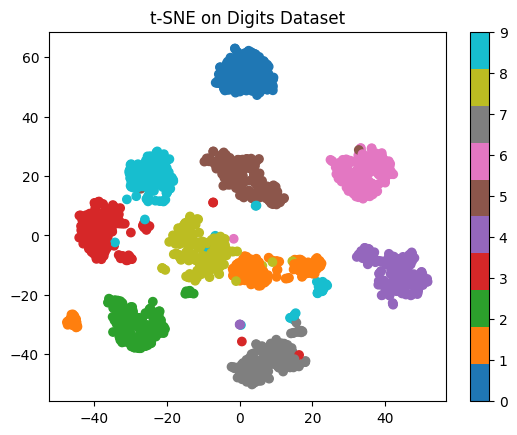

In [1]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load Digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="tab10")
plt.colorbar()
plt.title("t-SNE on Digits Dataset")
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# 1. Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.values  # Data (features)
y = mnist.target.astype(int)  # Target labels (digits)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
from sklearn.decomposition import PCA
# 2. Select the first 1000 samples
X_subset = X[:1000]
y_subset = y[:1000]

X_scaled = PCA(n_components=30).fit_transform(X_subset)

In [6]:
X_scaled.shape

(1000, 30)

In [17]:
a = np.array([[1,2,3,4,5,6],
             [7,8,9,10,11,12],
             [13,14,15,16,17,18],
             [19,20,21,22,23,24]])
a = a[2] - a
a

array([[12, 12, 12, 12, 12, 12],
       [ 6,  6,  6,  6,  6,  6],
       [ 0,  0,  0,  0,  0,  0],
       [-6, -6, -6, -6, -6, -6]])

In [44]:
norm = np.linalg.norm(a[0]-a, axis=1)

In [11]:
# std_norm = np.std(norm) 
# std_norm
# np.exp(norm)
p = np.zeros(shape=(5))
p

array([0., 0., 0., 0., 0.])

In [7]:
def calculate_pairwise_similarities(X: np.ndarray,
                                    perplexity: int=10) -> np.ndarray:
    """
    Input:-
    X: Each row denotes a datapoint. While number of columns = dimensionality of data
    perplexity: Desired perplexity

    Output:-
    Pairwise similarities in the high dimension

    How to find:
    for each row:
        find respective variance for the desired perplexity
        Use the formula to calculate the pairwise affinity
    """
    size = len(X)
    p_ij = np.zeros(shape=(size,size))
    for i in range(0, size):
        X_dist = X[i] - X
        var = find_variance_for_perplexity(X, i, perplexity)
        # print(var)
        norm = np.linalg.norm(X_dist, axis = 1)
        norm = np.exp(-(norm**2) / (2*(var**2)))
        norm[i] = 0
        p_ij[i,:] = norm / np.sum(norm)

    return p_ij

a = calculate_pairwise_similarities(X_scaled, 32)

NameError: name 'find_variance_for_perplexity' is not defined

In [8]:
# Binary search for finding the right variance for desired perplexity
def find_variance_for_perplexity(X_dist: np.ndarray,
                                 i: int,
                                 desired_perplexity: int) -> float:
    # Euclidean norm
    norm = np.linalg.norm(X_dist, axis = 1)
    std_dev = np.std(norm)
    start = 0.01 * std_dev
    end = 5 * std_dev
    tolerance = np.inf
    variance = np.inf

    for var_search in np.linspace(start, end, 500):
        # Calculate Shannon Entropy
        p = np.exp(-(norm**2) / (2*(var_search**2)))
        # Set similarity to zero for i==j
        p[i] = 0
        # To avoid log of zero while calculating Shannon entropy, 
        # we assign a small floating point number just greater than zero.
        small_num = np.nextafter(0, 1)
        p = np.maximum(p / np.sum(p), small_num)
        
        # Shannon Entropy
        H = -np.sum(p * np.log2(p))

        if abs(np.log(desired_perplexity) - H * np.log(2)) < abs(tolerance):
            tolerance = abs(np.log(desired_perplexity) - H * np.log(2))
            variance = var_search
    
    return variance

# find_variance_for_perplexity(X_scaled, 0, 10)    

In [41]:
def get_low_dimensional_similarity(Y: np.ndarray) -> np.ndarray:
    n = len(Y)
    Y_sim = np.zeros(shape=(n,n))
    for i in range(0,n):
        Y_diff = Y[i] - Y
        norm = np.linalg.norm(Y_diff, axis = 1)
        norm = np.exp(-(norm**2))
        Y_sim[i,:] = norm / np.sum(norm)

    return Y_sim

Y_t_1 = np.random.normal(loc=0, scale=10**(-2), size=(50, 2))
q_ij = get_low_dimensional_similarity(Y_t_1)

In [45]:
def get_gradient(p_ij: np.ndarray,
                 q_ij: np.ndarray,
                 Y: np.ndarray,
                 t: int) -> np.ndarray:
    n = len(p_ij)
    grad = np.zeros(shape=(n, Y.shape[1]))
    for i in range(0, n):
        part1 = np.array([(p_ij[i,:] - q_ij[i,:])])
        diff = Y[i] - Y
        norm = np.linalg.norm(diff, axis=1)
        part2 = np.array([(1 + norm**2) ** (-1)])
        part3 = diff
        if t <= 50:
            grad[i] = 4 * np.sum((part1*part2).T * part3, axis=0)
        else:
            grad[i] = np.sum((part1*part2).T * part3, axis=0)
    return grad

# pd.DataFrame(get_gradient(a, q_ij, Y_t_1, 40))

In [1]:
def TSNE_from_scratch(X: np.ndarray,
                      perplexity: int=10,
                      eta: float = 100, 
                      alpha: float = 0.5,
                      n_components: int = 2,
                      T: int=1000) -> np.ndarray:
    p_ij = calculate_pairwise_similarities(X, perplexity)
    n = len(p_ij)
    p_ij_adj = np.zeros(shape=(n,n))
    for i in range(0,n):
        for j in range(0,n):
            p_ij_adj[i][j] = (p_ij[i][j] + p_ij[j][i]) / (2 * n)        

    #Sample Y_0 = {y1, y2, ..., yn} from normal distribution around origin with variance 10^-4
    std_dev = 1e-4
    mean = 0
    # Y_t_2 = np.random.normal(loc=mean, scale=std_dev, size=(n, n_components))
    Y_t_2 = np.zeros(shape=(n, n_components))
    Y_t_1 = np.random.normal(loc=mean, scale=std_dev, size=(n, n_components))
    Y_t = np.zeros(shape=(n, n_components))

    for t in range(0,T):
        if t > 0:
            Y_t_2 = Y_t_1
            Y_t_1 = Y_t
        # Compute low dimensional affinities qij using eqn 4
        q_ij = get_low_dimensional_similarity(Y_t_1)

        # Compute gradient del C/ del Y using eqn 5
        grad = get_gradient(p_ij_adj, q_ij, Y_t_1, t)
        
        alpha = 0.5 if t < 250 else 0.8
        
        # Set Y_t = Y_t_1 + eta* del C/del Y + alpha* (Y_t_1 - Y_t_2)
        Y_t = Y_t_1 + (eta * grad) + (alpha * (Y_t_1 - Y_t_2))

        if t % 50 == 0:
            cost = np.sum(p_ij_adj * np.log(p_ij_adj / q_ij))
            print(f"Cost for iteration {t+1} is: ", cost)

    return Y_t

NameError: name 'np' is not defined

In [63]:
Y = TSNE_from_scratch(X_scaled, perplexity=15)

<ipython-input-32-8f34f7a242dd>:21: RuntimeWarning: invalid value encountered in divide
  p = np.maximum(p / np.sum(p), small_num)
<ipython-input-60-85670f51a50f>:38: RuntimeWarning: divide by zero encountered in log
  cost = np.sum(p_ij_adj * np.log(p_ij_adj / q_ij))
<ipython-input-60-85670f51a50f>:38: RuntimeWarning: invalid value encountered in multiply
  cost = np.sum(p_ij_adj * np.log(p_ij_adj / q_ij))


Cost for iteration 1 is:  nan


<ipython-input-60-85670f51a50f>:38: RuntimeWarning: divide by zero encountered in divide
  cost = np.sum(p_ij_adj * np.log(p_ij_adj / q_ij))
<ipython-input-60-85670f51a50f>:38: RuntimeWarning: overflow encountered in divide
  cost = np.sum(p_ij_adj * np.log(p_ij_adj / q_ij))


Cost for iteration 51 is:  nan
Cost for iteration 101 is:  nan
Cost for iteration 151 is:  nan
Cost for iteration 201 is:  nan
Cost for iteration 251 is:  nan
Cost for iteration 301 is:  nan
Cost for iteration 351 is:  nan
Cost for iteration 401 is:  nan
Cost for iteration 451 is:  nan
Cost for iteration 501 is:  nan
Cost for iteration 551 is:  nan
Cost for iteration 601 is:  nan
Cost for iteration 651 is:  nan
Cost for iteration 701 is:  nan
Cost for iteration 751 is:  nan
Cost for iteration 801 is:  nan
Cost for iteration 851 is:  nan
Cost for iteration 901 is:  nan
Cost for iteration 951 is:  nan


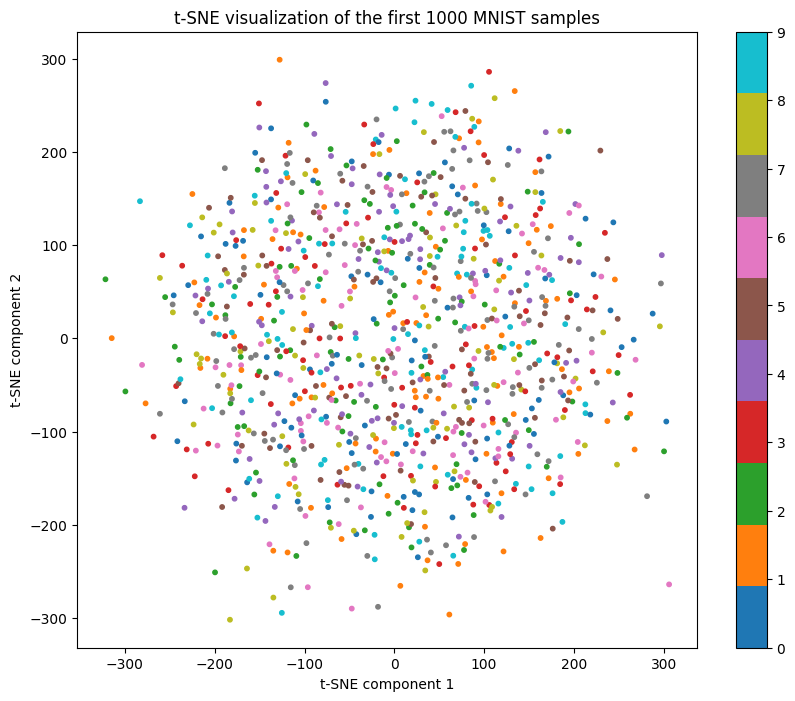

In [64]:
plt.figure(figsize=(10, 8))
plt.scatter(Y[:, 0], Y[:, 1], c=y_subset, cmap='tab10', s=10)
plt.colorbar()  # Show color bar
plt.title('t-SNE visualization of the first 1000 MNIST samples')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Fetch MNIST data
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

# X_total = pd.DataFrame(mnist["data"])
# y_total = pd.DataFrame(mnist["target"])

# X_reduced = X_total.sample(n=1000)
# y_reduced = y_total.loc[X_total.index]

# # PCA to keep 30 components
# X = PCA(n_components=30).fit_transform(X_reduced) 

In [73]:
X_total = pd.DataFrame(mnist["data"])
y_total = pd.DataFrame(mnist["target"])

X_reduced = X_total.sample(n=500)
y_reduced = y_total.loc[X_total.index]

# PCA to keep 30 components
X = PCA(n_components=30).fit_transform(X_reduced) 

In [5]:
print(X_total.shape)
print(y_total.shape)

(70000, 784)
(70000, 1)


In [22]:
y_reduced[:1000].shape

(1000, 1)

In [74]:
X.shape

(500, 30)

In [65]:
def get_original_pairwise_affinities(X: np.ndarray, perplexity: int = 10) -> np.ndarray:
    """
    Function to obtain affinities matrix.

    Parameters:
    X (np.ndarray): The input data array.
    perplexity (int): The perplexity value for the grid search.

    Returns:
    np.ndarray: The pairwise affinities matrix.
    """

    n = len(X)

    print("Computing Pairwise Affinities....")

    p_ij = np.zeros(shape=(n, n))
    for i in range(0, n):
        # Equation 1 numerator
        diff = X[i] - X
        σ_i = grid_search(diff, i, perplexity)  # Grid Search for σ_i
        norm = np.linalg.norm(diff, axis=1)
        p_ij[i, :] = np.exp(-(norm**2) / (2 * σ_i**2))

        # Set p = 0 when j = i
        np.fill_diagonal(p_ij, 0)

        # Equation 1
        p_ij[i, :] = p_ij[i, :] / np.sum(p_ij[i, :])

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0, 1)
    p_ij = np.maximum(p_ij, ε)

    print("Completed Pairwise Affinities Matrix. \n")

    return p_ij

In [66]:
def grid_search(diff_i: np.ndarray, i: int, perplexity: int) -> float:
    """
    Helper function to obtain σ's based on user-specified perplexity.

    Parameters:
        diff_i (np.ndarray): Array containing the pairwise differences between data points.
        i (int): Index of the current data point.
        perplexity (int): User-specified perplexity value.

    Returns:
        float: The value of σ that satisfies the perplexity condition.
    """

    result = np.inf  # Set first result to be infinity

    norm = np.linalg.norm(diff_i, axis=1)
    std_norm = np.std(norm)  # Use standard deviation of norms to define search space

    for σ_search in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
        # Equation 1 Numerator
        p = np.exp(-(norm**2) / (2 * σ_search**2))

        # Set p = 0 when i = j
        p[i] = 0

        # Equation 1 (ε -> 0)
        ε = np.nextafter(0, 1)
        p_new = np.maximum(p / np.sum(p), ε)

        # Shannon Entropy
        H = -np.sum(p_new * np.log2(p_new))

        # Get log(perplexity equation) as close to equality
        if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
            result = np.log(perplexity) - H * np.log(2)
            σ = σ_search

    return σ

In [67]:
def get_symmetric_p_ij(p_ij: np.ndarray) -> np.ndarray:
    """
    Function to obtain symmetric affinities matrix utilized in t-SNE.

    Parameters:
    p_ij (np.ndarray): The input affinity matrix.

    Returns:
    np.ndarray: The symmetric affinities matrix.

    """
    print("Computing Symmetric p_ij matrix....")

    n = len(p_ij)
    p_ij_symmetric = np.zeros(shape=(n, n))
    for i in range(0, n):
        for j in range(0, n):
            p_ij_symmetric[i, j] = (p_ij[i, j] + p_ij[j, i]) / (2 * n)

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0, 1)
    p_ij_symmetric = np.maximum(p_ij_symmetric, ε)

    print("Completed Symmetric p_ij Matrix. \n")

    return p_ij_symmetric

In [68]:
def initialization(
    X: np.ndarray, n_dimensions: int = 2, initialization: str = "random"
) -> np.ndarray:
    """
    Obtain initial solution for t-SNE either randomly or using PCA.

    Parameters:
        X (np.ndarray): The input data array.
        n_dimensions (int): The number of dimensions for the output solution. Default is 2.
        initialization (str): The initialization method. Can be 'random' or 'PCA'. Default is 'random'.

    Returns:
        np.ndarray: The initial solution for t-SNE.

    Raises:
        ValueError: If the initialization method is neither 'random' nor 'PCA'.
    """

    # Sample Initial Solution
    if initialization == "random" or initialization != "PCA":
        y0 = np.random.normal(loc=0, scale=1e-4, size=(len(X), n_dimensions))
    elif initialization == "PCA":
        X_centered = X - X.mean(axis=0)
        _, _, Vt = np.linalg.svd(X_centered)
        y0 = X_centered @ Vt.T[:, :n_dimensions]
    else:
        raise ValueError("Initialization must be 'random' or 'PCA'")

    return y0

In [69]:
def get_low_dimensional_affinities(Y: np.ndarray) -> np.ndarray:
    """
    Obtain low-dimensional affinities.

    Parameters:
    Y (np.ndarray): The low-dimensional representation of the data points.

    Returns:
    np.ndarray: The low-dimensional affinities matrix.
    """

    n = len(Y)
    q_ij = np.zeros(shape=(n, n))

    for i in range(0, n):
        # Equation 4 Numerator
        diff = Y[i] - Y
        norm = np.linalg.norm(diff, axis=1)
        q_ij[i, :] = (1 + norm**2) ** (-1)

    # Set p = 0 when j = i
    np.fill_diagonal(q_ij, 0)

    # Equation 4
    q_ij = q_ij / q_ij.sum()

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0, 1)
    q_ij = np.maximum(q_ij, ε)

    return q_ij

In [70]:
def get_gradient(p_ij: np.ndarray, q_ij: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Obtain gradient of cost function at current point Y.

    Parameters:
    p_ij (np.ndarray): The joint probability distribution matrix.
    q_ij (np.ndarray): The Student's t-distribution matrix.
    Y (np.ndarray): The current point in the low-dimensional space.

    Returns:
    np.ndarray: The gradient of the cost function at the current point Y.
    """

    n = len(p_ij)

    # Compute gradient
    gradient = np.zeros(shape=(n, Y.shape[1]))
    for i in range(0, n):
        # Equation 5
        diff = Y[i] - Y
        A = np.array([(p_ij[i, :] - q_ij[i, :])])
        B = np.array([(1 + np.linalg.norm(diff, axis=1)) ** (-1)])
        C = diff
        gradient[i] = 4 * np.sum((A * B).T * C, axis=0)

    return gradient

In [71]:
def tsne(
    X: np.ndarray,
    perplexity: int = 10,
    T: int = 1000,
    η: int = 200,
    early_exaggeration: int = 4,
    n_dimensions: int = 2,
) -> list[np.ndarray, np.ndarray]:
    """
    t-SNE (t-Distributed Stochastic Neighbor Embedding) algorithm implementation.

    Args:
        X (np.ndarray): The input data matrix of shape (n_samples, n_features).
        perplexity (int, optional): The perplexity parameter. Default is 10.
        T (int, optional): The number of iterations for optimization. Default is 1000.
        η (int, optional): The learning rate for updating the low-dimensional embeddings. Default is 200.
        early_exaggeration (int, optional): The factor by which the pairwise affinities are exaggerated
            during the early iterations of optimization. Default is 4.
        n_dimensions (int, optional): The number of dimensions of the low-dimensional embeddings. Default is 2.

    Returns:
        list[np.ndarray, np.ndarray]: A list containing the final low-dimensional embeddings and the history
            of embeddings at each iteration.

    """
    n = len(X)

    # Get original affinities matrix
    p_ij = get_original_pairwise_affinities(X, perplexity)
    p_ij_symmetric = get_symmetric_p_ij(p_ij)

    # Initialization
    Y = np.zeros(shape=(T, n, n_dimensions))
    Y_minus1 = np.zeros(shape=(n, n_dimensions))
    Y[0] = Y_minus1
    Y1 = initialization(X, n_dimensions)
    Y[1] = np.array(Y1)

    print("Optimizing Low Dimensional Embedding....")
    # Optimization
    for t in range(1, T - 1):
        # Momentum & Early Exaggeration
        if t < 250:
            α = 0.5
            early_exaggeration = early_exaggeration
        else:
            α = 0.8
            early_exaggeration = 1

        # Get Low Dimensional Affinities
        q_ij = get_low_dimensional_affinities(Y[t])

        # Get Gradient of Cost Function
        gradient = get_gradient(early_exaggeration * p_ij_symmetric, q_ij, Y[t])

        # Update Rule
        Y[t + 1] = Y[t] - η * gradient + α * (Y[t] - Y[t - 1])  # Use negative gradient

        # Compute current value of cost function
        if t % 50 == 0 or t == 1:
            cost = np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))
            print(f"Iteration {t}: Value of Cost Function is {cost}")

    print(
        f"Completed Low Dimensional Embedding: Final Value of Cost Function is {np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))}"
    )
    solution = Y[-1]

    return solution, Y

In [75]:
solution, Y = tsne(X)

Computing Pairwise Affinities....


<ipython-input-66-b975a6496870>:28: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), ε)


Completed Pairwise Affinities Matrix. 

Computing Symmetric p_ij matrix....
Completed Symmetric p_ij Matrix. 

Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 3.7662617881349134
Iteration 50: Value of Cost Function is 2.714101239447519
Iteration 100: Value of Cost Function is 2.6230524467674097
Iteration 150: Value of Cost Function is 2.6241193983233337
Iteration 200: Value of Cost Function is 2.6240250483899428
Iteration 250: Value of Cost Function is 2.6256347873841452
Iteration 300: Value of Cost Function is 0.8577920413498802
Iteration 350: Value of Cost Function is 0.8322848279419858
Iteration 400: Value of Cost Function is 0.821939937995416
Iteration 450: Value of Cost Function is 0.8176758767425545
Iteration 500: Value of Cost Function is 0.8149899638547893
Iteration 550: Value of Cost Function is 0.8131281143799972
Iteration 600: Value of Cost Function is 0.8117570818398157
Iteration 650: Value of Cost Function is 0.8107030019286953
Iteration 700

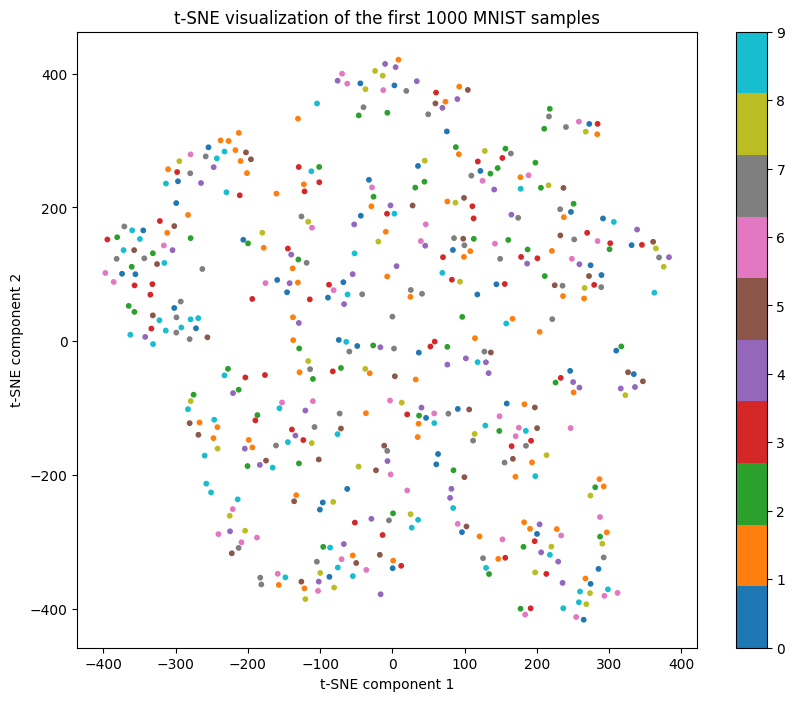

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(solution[:, 0], solution[:, 1], c=y_subset[:500], cmap='tab10', s=10)
plt.colorbar()  # Show color bar
plt.title('t-SNE visualization of the first 1000 MNIST samples')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()